<a href="https://colab.research.google.com/github/m-a-hasan/ai-colab/blob/main/10_time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Books**
- https://otexts.com/fpp3/tspatterns.html

In [ ]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers

In [ ]:
# Download bitcoin data 01/10/2013 - 18/05/2021
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-01-28 07:58:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2023-01-28 07:58:23 (7.25 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [ ]:
# Parse csv file into df
import pandas as pd

df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # make Date column as the index for the table
df.head(10)

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566
2013-10-06,BTC,120.65533,121.33866,121.85216,120.55450
2013-10-07,BTC,121.79500,120.65533,121.99166,120.43199
2013-10-08,BTC,123.03300,121.79500,123.64016,121.35066
2013-10-09,BTC,124.04900,123.03300,124.78350,122.59266


In [ ]:
# Table info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [ ]:
# Sample size
len(df)

2787

In [ ]:
df["Closing Price (USD)"].head(20)

Date
2013-10-01    123.65499
2013-10-02    125.45500
2013-10-03    108.58483
2013-10-04    118.67466
2013-10-05    121.33866
2013-10-06    120.65533
2013-10-07    121.79500
2013-10-08    123.03300
2013-10-09    124.04900
2013-10-10    125.96116
2013-10-11    125.27966
2013-10-12    125.92750
2013-10-13    126.38333
2013-10-14    135.24199
2013-10-15    133.20333
2013-10-16    142.76333
2013-10-17    137.92333
2013-10-18    142.95166
2013-10-19    152.55183
2013-10-20    160.33883
Name: Closing Price (USD), dtype: float64

In [ ]:
# keep just the date and closing price
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head(10)

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866
2013-10-06,120.65533
2013-10-07,121.79500
2013-10-08,123.03300
2013-10-09,124.04900


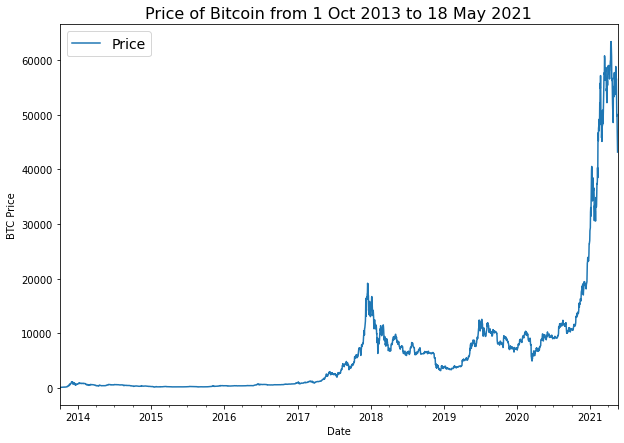

In [ ]:
from numpy import size
# Visualize data
import matplotlib.pyplot as plt

bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14)

**Train-Test set the wrong way**

For timeseries data, unfortunately Scikit-learn's train_test_split() doesn't work

In [ ]:
# Make date and price into numpy arrays
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

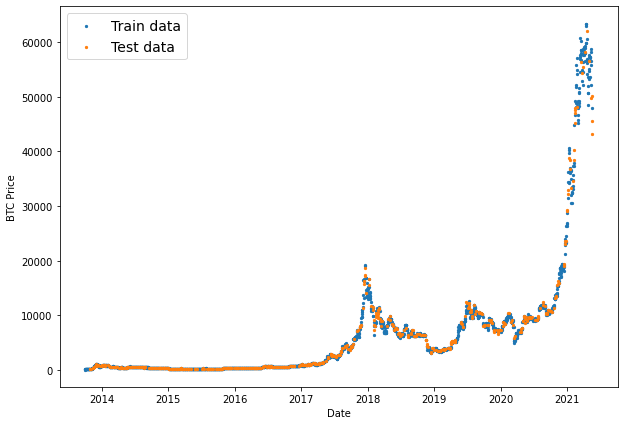

In [ ]:
# Plot train and test split
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show()

Here, train and test data randomly mixed up which is fine for other problems, but for time series problem, we will have to make sure the split is between historical data (train data) and future data (test data)

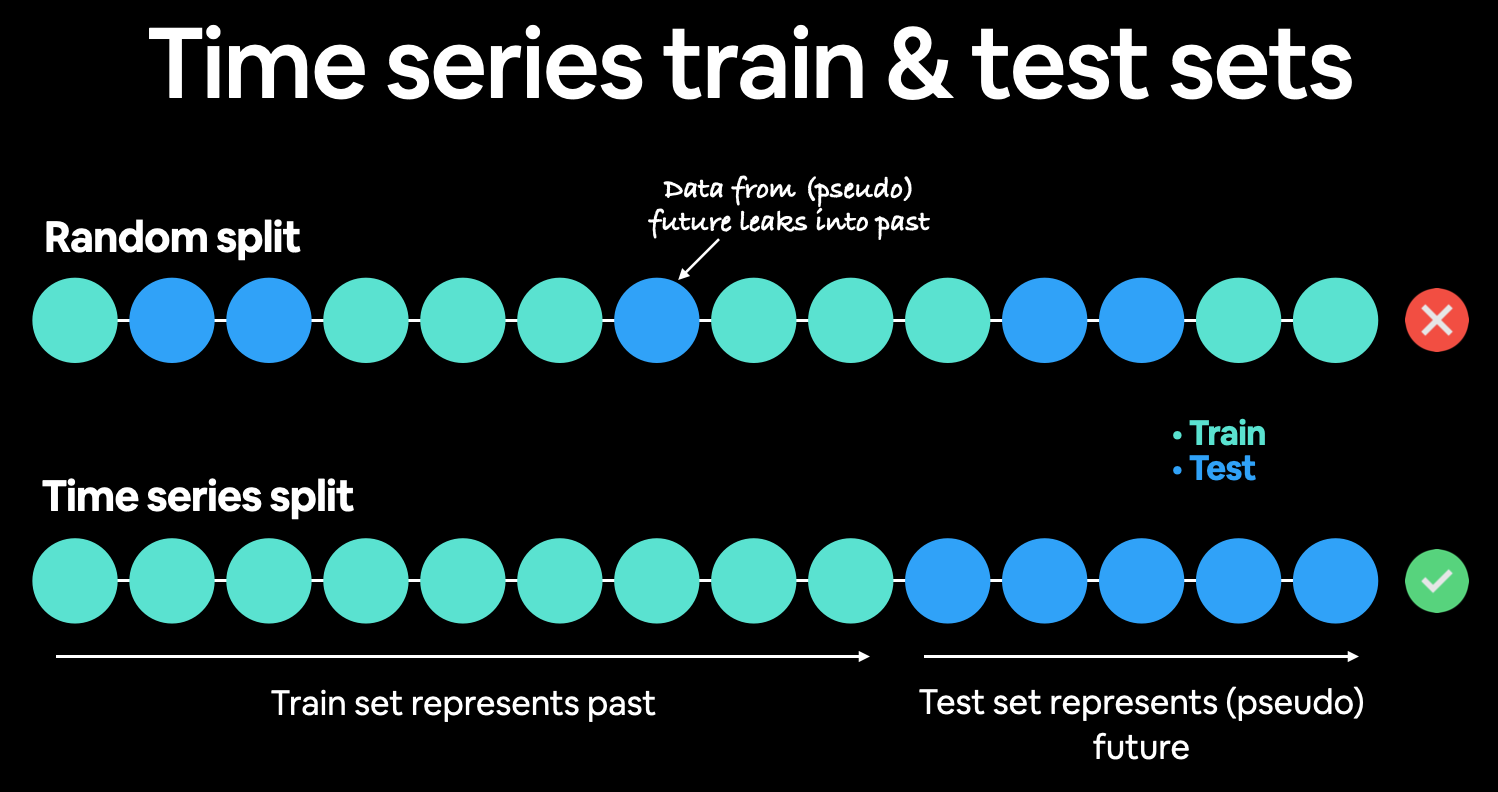

**Train_Test split the right way**

In [ ]:
split_size = int(0.8 * len(prices)) # 80% train data

X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2229,), (2229,), (558,), (558,))

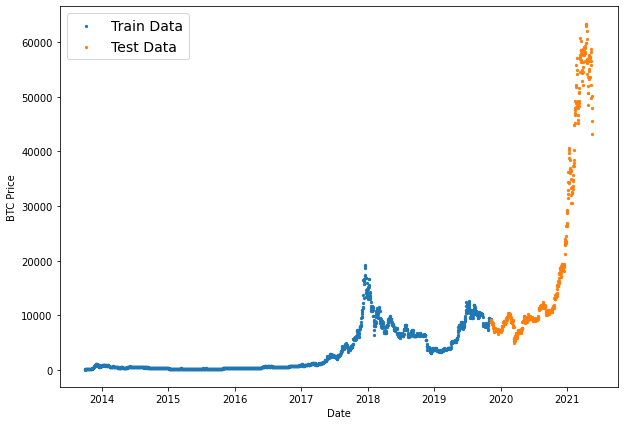

In [ ]:
# Visualize
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train Data")
plt.scatter(X_test, y_test, s=5, label="Test Data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show()

In [ ]:
# Function to plot timeseries data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots a time series against values

  Parameters
  ---------
  timesteps: array of timesteps
  values: array of values against the timesteps
  format: format of the char, default is .
  start: index of where to start the plot
  end: index of where to end the plot
  label: label of the chart
  """
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

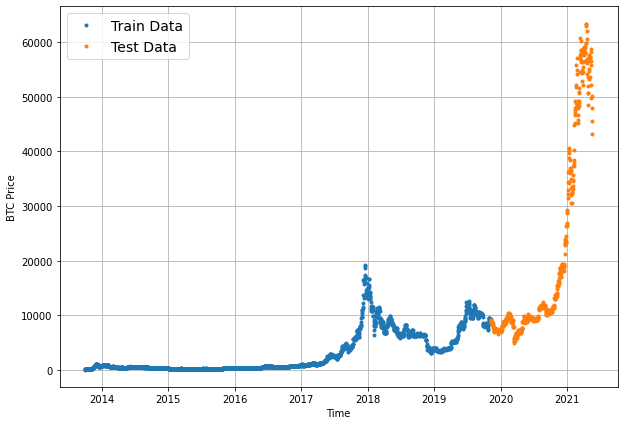

In [ ]:
# Try plotting function
plt.figure(figsize=(10, 7))
plot_time_series(X_train, y_train, label="Train Data")
plot_time_series(X_test, y_test, label="Test Data")

**Horizon** - number of timesteps to predict into the future

**Window** - number of timesteps from the past to predict horizon

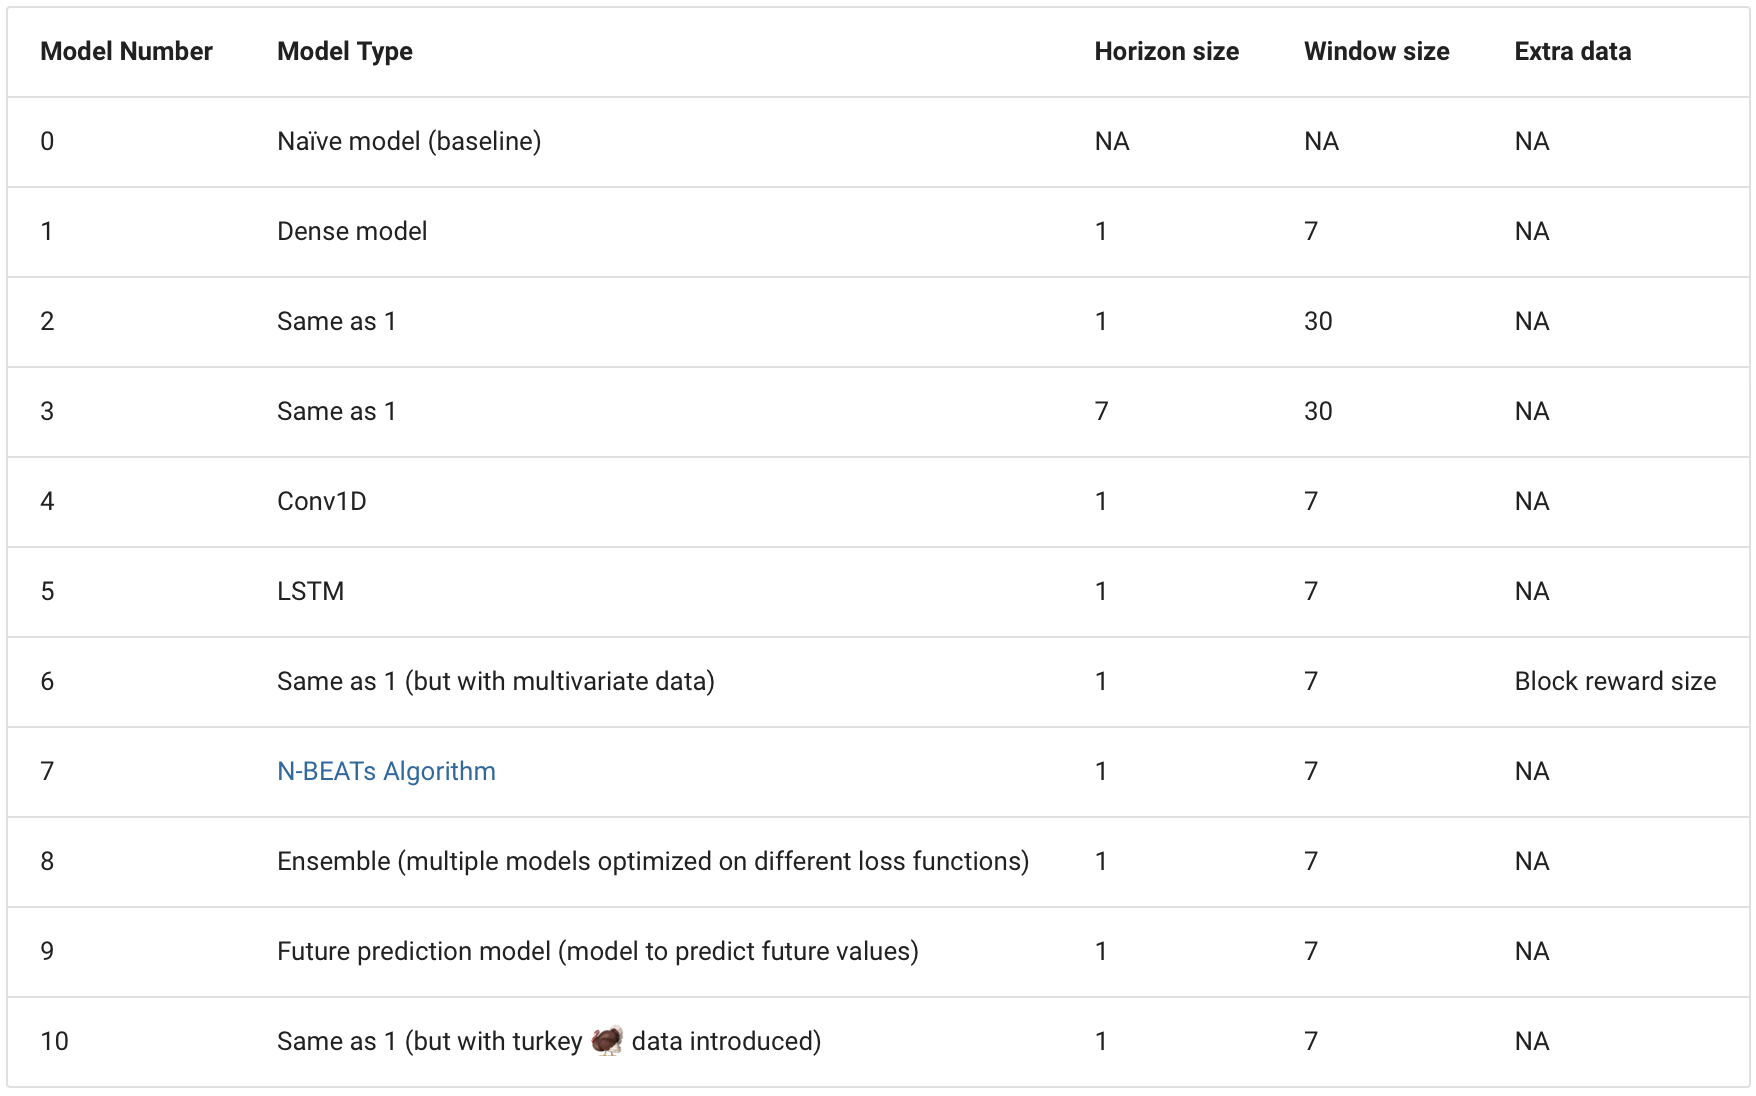

**Model 0:** Base model (Naive forecast)
- It feels to be stupid because all it does is say today's price will be the price of yesterday. However, it is actually hard to beat Naive forecast)

In [ ]:
naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

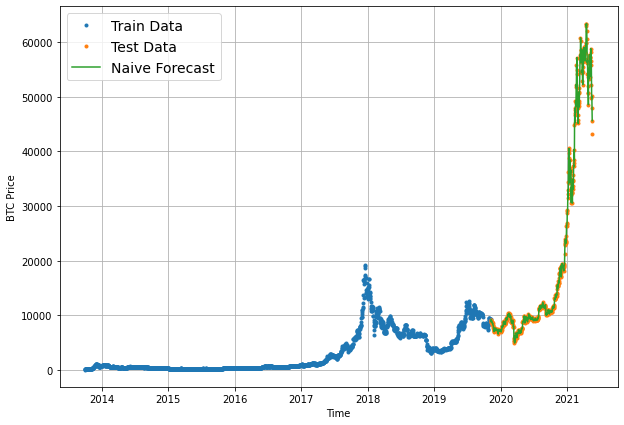

In [ ]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(X_train, y_train, label="Train Data")
plot_time_series(X_test, y_test, label="Test Data")
plot_time_series(X_test[1:], naive_forecast, format="-", label="Naive Forecast")

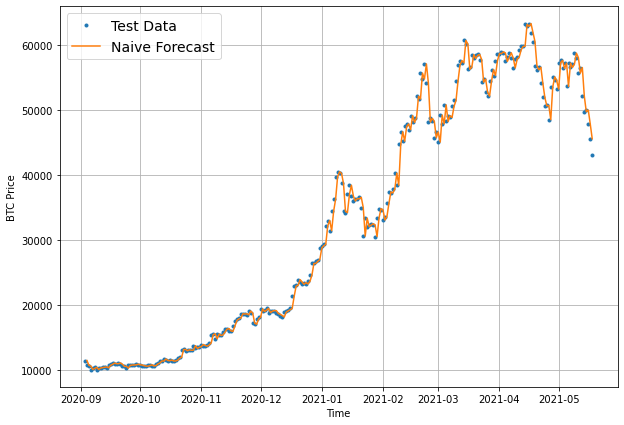

In [ ]:
# Use offset to view after 300 timesteps
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test Data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive Forecast")

We are predicting numbers (btc price) which is a regression problem. To evaluate our model, we will use below metrics (the lower the metrics, the better the model is)

- Scale-dependent errors
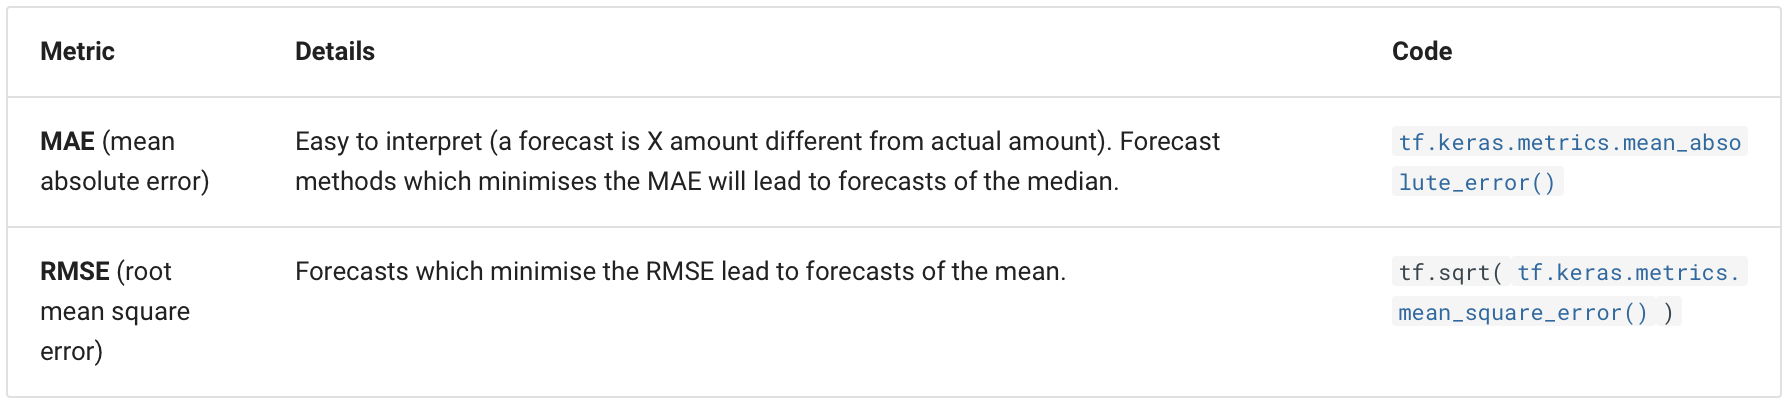

- Percentage errors
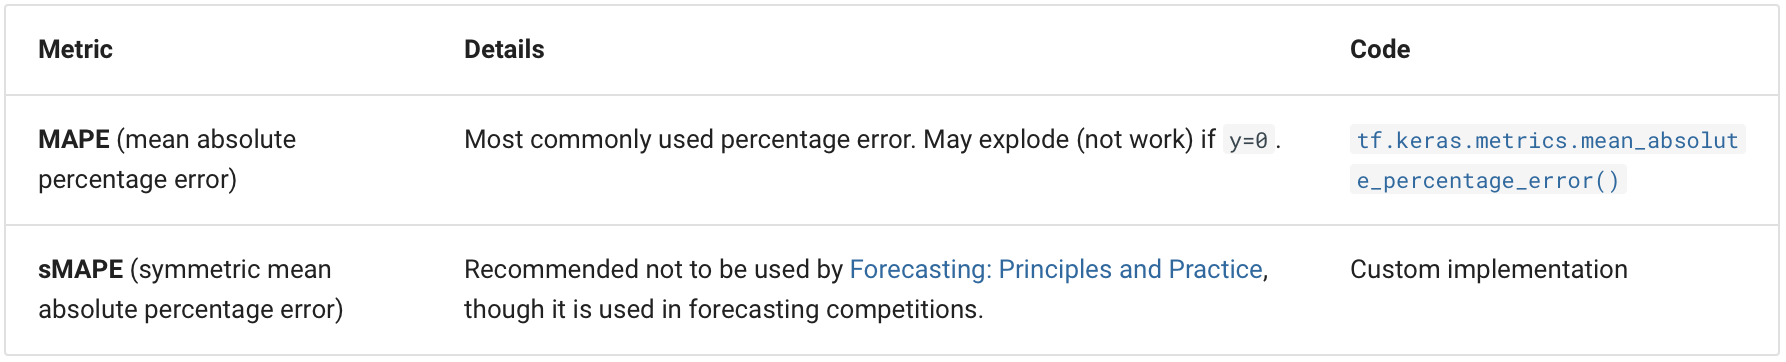

- Scaled errors
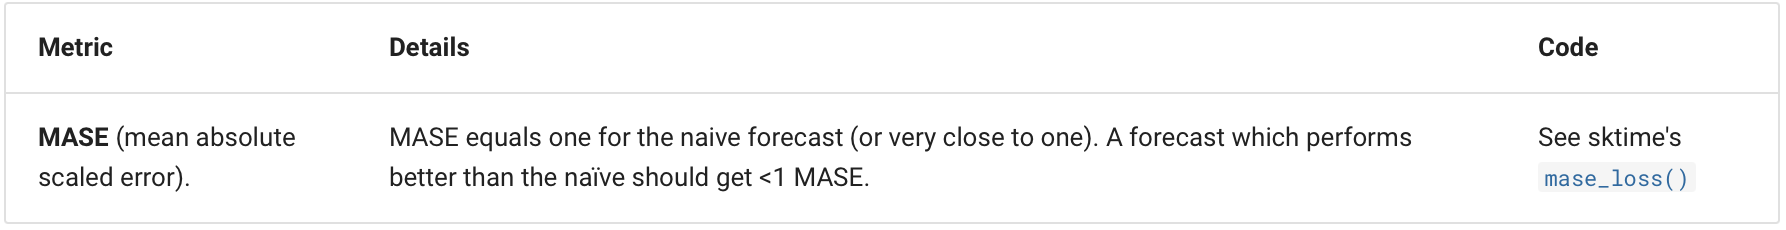


In [ ]:
# Create function to calculate MASE as there is no default tensorflow function for that
# Courtesy of - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Calcualte MASE
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # assuming our seasonality is 1 day
  return mae / mae_naive_no_season

In [ ]:
# Create function to evaluate different error metrics (the less the better)
def evaluate_preds(y_true, y_pred):
  """
  Evaluates predictions with different metrics
  """
  # Cast params into float 32
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # accentuate outliers by squaring every value
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {
      "mae": mae.numpy(),
      "mse": mse.numpy(),
      "rmse": rmse.numpy(),
      "mape": mape.numpy(),
      "mase": mase.numpy()
  }

In [ ]:
# Test evaluation function on naive forecast
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

In [ ]:
average_btc_price = tf.reduce_mean(y_test).numpy()
average_btc_price

20056.632963737226

So, average BTC price is \$20,056.63 and naive base is off by \$567.98 each prediction

**Extra models to try and beat our best performing model**
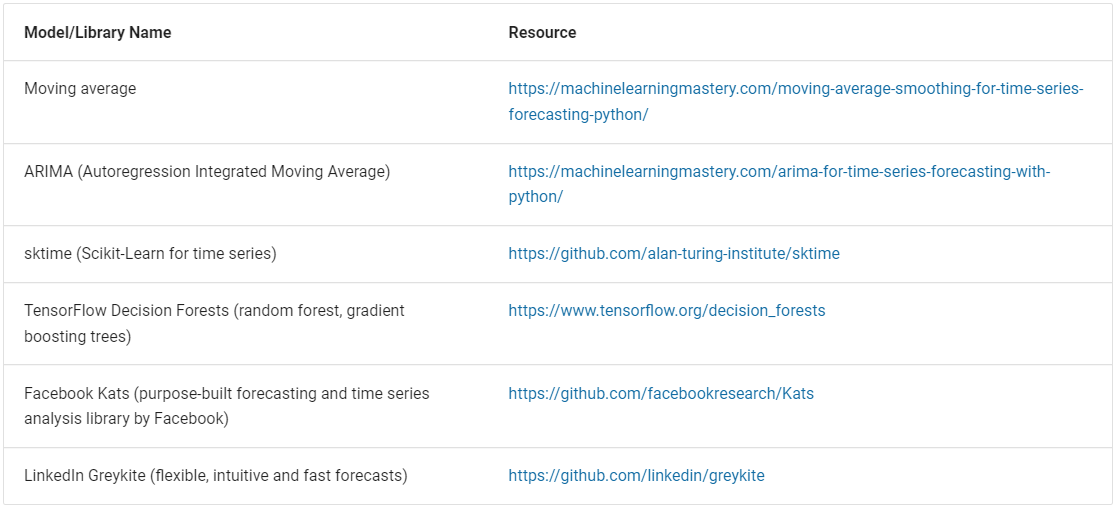

**Windowing dataset**

For univariate time series, windowing for one week (window = 7) to predict next single value (horizon = 1) looks like,

[0, 1, 2, 3, 4, 5, 6] -> [7]

[1, 2, 3, 4, 5, 6, 7] -> [8]

[2, 3, 4, 5, 6, 7, 8] -> [9]

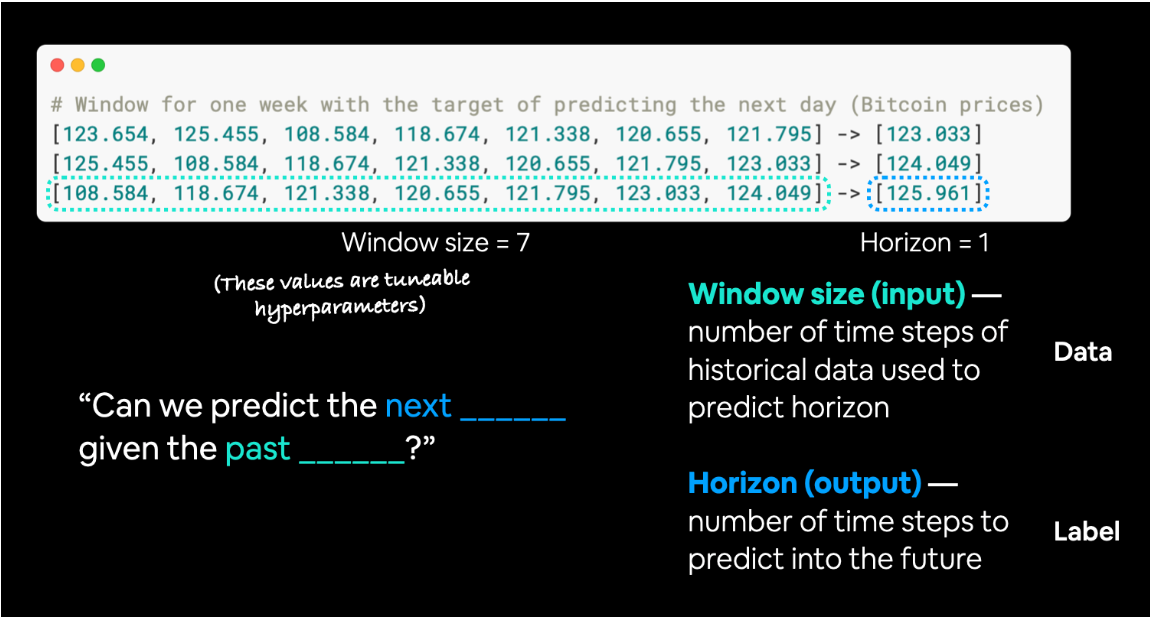

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Function to turning array into window and horizon
def get_labelled_windows(x, horizon=1):
  """
  E.g. if horizon = 1 (default)
  Input: [1, 2, 3, 4, 5, 6]
  Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
# Test window label function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()}\nHorizon: {tf.squeeze(test_label).numpy()}\nHorizon Data Type: {type(tf.squeeze(test_label.numpy()))}")

Window: [1 2 3 4 5 6 7]
Horizon: 8
Horizon Data Type: <class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
tf.range(8), tf.range(8)+1, tf.expand_dims(tf.range(8)+1, axis=0)

(<tf.Tensor: shape=(8,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)>,
 <tf.Tensor: shape=(8,), dtype=int32, numpy=array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)>,
 <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7, 8]], dtype=int32)>)

Create window and label based on window size and horizon (add label as the last value)
1. Create window [[0, 1, 2, 3, 4, 5, 6, 7]]
2. Create 2D window

[[0, 1, 2, 3, 4, 5, 6, 7],
[1, 2, 3, 4, 5, 6, 7, 8],
[2, 3, 4, 5, 6, 7, 8, 9]]

In [ ]:
# The function created below has been adapted from https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5
def make_windows(x, window_size=7, horizon=1):
  """
  Turns 1D array into 2D array of window size with labels
  """
  # Create window with specific size
  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

  # Create 2D array of windows (to use as index)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T

  # Index on target array
  windowed_array = x[window_indexes]

  # Get window and labels
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [ ]:
x = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
window_step = [[0, 1, 2, 3, 4, 5, 6, 7]]
print(f"{np.arange(8)}\n{np.expand_dims(np.arange(8), axis=0)}")
print(f"{np.arange(len(x) - 7)}\n{np.expand_dims(np.arange(len(x)-(7)), axis=0).T}\n{window_step + np.expand_dims(np.arange(len(x)-7), axis=0).T}")

[0 1 2 3 4 5 6 7]
[[0 1 2 3 4 5 6 7]]
[0 1 2 3]
[[0]
 [1]
 [2]
 [3]]
[[ 0  1  2  3  4  5  6  7]
 [ 1  2  3  4  5  6  7  8]
 [ 2  3  4  5  6  7  8  9]
 [ 3  4  5  6  7  8  9 10]]


In [ ]:
x = [[2, 3, 4, 5, 6, 7, 8, 9]]
x = np.array(x)
y = [[10], [12], [15], [16]]
y = np.array(y)
x + y

array([[12, 13, 14, 15, 16, 17, 18, 19],
       [14, 15, 16, 17, 18, 19, 20, 21],
       [17, 18, 19, 20, 21, 22, 23, 24],
       [18, 19, 20, 21, 22, 23, 24, 25]])

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_labels), len(full_windows)

(2780, 2780)

In [ ]:
# View first 3 windows and their labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [ ]:
# Last 3 windows and their labels
ind = len(full_windows)
for i in range(ind-3, ind):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


In [ ]:
# Tests same but with less lines
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


In [ ]:
# Create function to split train and test data
def make_train_test_splits(windows, labels, test_split=0.2):
  split_size = int(len(windows) * (1 - test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, train_labels, test_windows, test_labels

In [ ]:
# Test the function
train_windows, train_labels, test_windows, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2224, 2224, 556, 556)

In [ ]:
# Check first 5 elements of training data
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

Create ModelCheckpoint to save only best model (so we can compare models at their best irrespective of the epochs)

In [ ]:
import os

# Function to save the best model using callback
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

**Model 1: Dense Model** (window=7, horizon=1)

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear"), # linear activation is same as having no activation
], name="model_1_dense")

In [ ]:
model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="mae",
                metrics=["mae"])

In [ ]:
# Fit
model_1.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_1.name)])

Epoch 1/100
18/18 [==============================] - 3s 93ms/step - loss: 780.3469 - mae: 780.3469 - val_loss: 2279.5828 - val_mae: 2279.5828
Epoch 2/100
18/18 [==============================] - 1s 59ms/step - loss: 247.6765 - mae: 247.6765 - val_loss: 1005.9865 - val_mae: 1005.9865
Epoch 3/100
18/18 [==============================] - 1s 57ms/step - loss: 188.4107 - mae: 188.4107 - val_loss: 923.2861 - val_mae: 923.2861
Epoch 4/100
18/18 [==============================] - 1s 53ms/step - loss: 169.4334 - mae: 169.4334 - val_loss: 900.5931 - val_mae: 900.5931
Epoch 5/100
18/18 [==============================] - 1s 71ms/step - loss: 165.0900 - mae: 165.0900 - val_loss: 895.2404 - val_mae: 895.2404
Epoch 6/100
18/18 [==============================] - 2s 106ms/step - loss: 158.5206 - mae: 158.5206 - val_loss: 855.1868 - val_mae: 855.1868
Epoch 7/100
18/18 [==============================] - 1s 64ms/step - loss: 151.3568 - mae: 151.3568 - val_loss: 840.9289 - val_mae: 840.9289
Epoch 8/100
18/

In [ ]:
# Evaluate
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 662.5322 - mae: 662.5322


[662.5322265625, 662.5322265625]

In [ ]:
# Load the best saved model_1
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 568.5499 - mae: 568.5499


[568.5498657226562, 568.5498657226562]

In [ ]:
# Function to make predictions
def make_preds(model, input_data):
  """
  Function to return prediction of a model based on test data

  Parameters
  ---------
  model: model used to predict
  input_data: test dataset with similar window size of training data of the model

  Returns
  ------
  Prediction on input_data
  """

  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [ ]:
# Prediction time
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 8ms/step


(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8874.493, 8789.944, 9040.986, 8804.829, 8741.21 , 8749.837,
        8705.865, 8513.171, 8478.415, 8536.302], dtype=float32)>)

In [ ]:
# Evaluate the prediction with ground truth
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 568.5498,
 'mse': 1172587.4,
 'rmse': 1082.8607,
 'mape': 2.549229,
 'mase': 0.99878454}

In [ ]:
# Baseline results
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

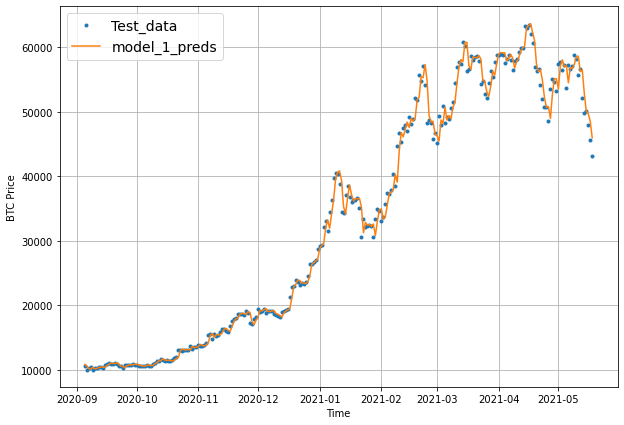

In [ ]:
# Visualization
offset = 300
plt.figure(figsize=(10, 7))

# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

**Model 2: Dense** (window=30, horizon=1)

In [ ]:
# Set window and horizon
WINDOW_SIZE = 30
HORIZON = 1

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [ ]:
# Make train test data
train_windows, train_labels, test_windows, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2205, 2205, 552, 552)

In [ ]:
# Set seed
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_2_dense")

In [ ]:
# Compile
model_2.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="mae",
                metrics=["mae"])

In [ ]:
# Fit
model_2.fit(x=train_windows,
            y=train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [ ]:
# Evaluate
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 658.0281 - mae: 658.0281


[658.028076171875, 658.028076171875]

In [ ]:
# Load best model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 608.8478 - mae: 608.8478


[608.8478393554688, 608.8478393554688]

In [ ]:
model_2_preds = make_preds(model=model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 2ms/step


In [ ]:
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)

In [ ]:
model_2_results

{'mae': 608.84796,
 'mse': 1284313.5,
 'rmse': 1133.2755,
 'mape': 2.7680647,
 'mase': 1.0642722}

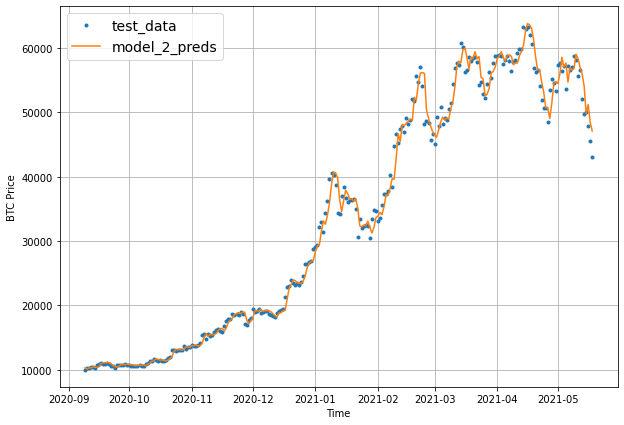

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

**Model 3: Dense (window=30, horizon=7)**

In [ ]:
WINDOW_SIZE = 30
HORIZON = 7

full_windows, full_labels = make_windows(x=prices,
                                         window_size=WINDOW_SIZE,
                                         horizon=HORIZON)

len(full_labels), len(full_windows)

(2751, 2751)

In [ ]:
train_windows, train_labels, test_windows, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2200, 2200, 551, 551)

In [ ]:
# Set seed
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_3_dense")

In [ ]:
model_3.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="mae",
                metrics=["mae"])

In [ ]:
model_3.fit(x=train_windows,
            y=train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            callbacks=[create_model_checkpoint(model_name=model_3.name)],
            validation_data=(test_windows, test_labels))

In [ ]:
# Evaluate
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1297.3754 - mae: 1297.3754


[1297.3753662109375, 1297.3753662109375]

In [ ]:
# Load best performing model
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1236.2075 - mae: 1236.2075


[1236.20751953125, 1236.20751953125]

In [ ]:
model_3_preds = make_preds(model_3, test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9066.453 , 9334.446 , 9461.401 , 9388.391 , 9463.582 , 9670.427 ,
        9430.584 ],
       [8755.7295, 9083.715 , 9226.223 , 8985.109 , 9058.751 , 9266.0625,
        9211.953 ],
       [8716.3545, 9035.204 , 9130.837 , 8909.687 , 9015.347 , 9136.23  ,
        9121.998 ],
       [8914.29  , 9065.095 , 9077.667 , 9093.83  , 9053.94  , 9326.763 ,
        9151.856 ],
       [8814.659 , 9023.546 , 8928.278 , 8960.1   , 9191.008 , 9366.611 ,
        9029.211 ]], dtype=float32)>

In [ ]:
model_3_results = evaluate_preds(tf.squeeze(test_labels), model_3_preds)
model_3_results

{'mae': array([  608.96844 ,   344.76828 ,   409.33035 ,   471.0399  ,
          490.4255  ,   600.3134  ,   610.6784  ,   538.9532  ,
          574.64154 ,   720.91125 ,   879.78284 ,   808.7538  ,
          791.4953  ,   857.7123  ,   631.0079  ,   285.35532 ,
          179.58748 ,   183.56947 ,   228.9442  ,   271.1052  ,
          128.55656 ,   206.18924 ,   263.39984 ,   323.2526  ,
          214.50551 ,   173.37088 ,   145.38805 ,   160.09402 ,
          177.30022 ,   236.22984 ,   360.91635 ,   425.67856 ,
          324.77322 ,   344.0058  ,   309.53043 ,   309.55023 ,
          367.54547 ,   295.3404  ,   239.49881 ,   156.17683 ,
          346.646   ,    90.05671 ,    98.09535 ,    92.904434,
          143.89754 ,    52.04827 ,   104.60673 ,   144.27791 ,
          152.39607 ,   145.75648 ,   167.4158  ,   183.91566 ,
          230.51297 ,   167.87012 ,   239.78084 ,   313.32846 ,
          494.19455 ,   496.88315 ,   469.7184  ,   481.3379  ,
          394.08463 ,   244.0648 

In [ ]:
# Make evaluate prediction work with multiple shapes
def evaluate_preds(y_true, y_pred):
  # Make data float32
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # If different size
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {
      "mae": mae.numpy(),
      "mse": mse.numpy(),
      "rmse": rmse.numpy(),
      "mape": mape.numpy(),
      "mase": mase.numpy()
  }

In [ ]:
# Evaluate model 3
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1236.2075,
 'mse': 5459194.0,
 'rmse': 1421.6143,
 'mape': 5.5906534,
 'mase': 2.1997616}

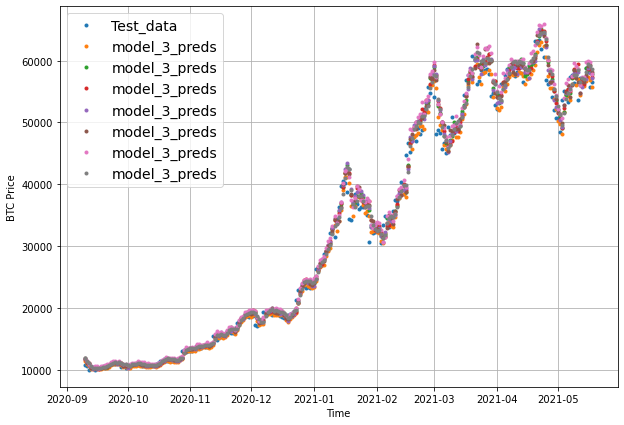

In [ ]:
# Visualization
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

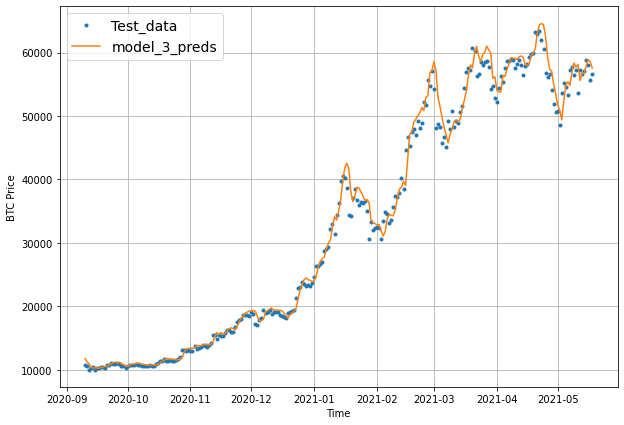

In [ ]:
# Fix visualization function
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 format="-",
                 start=offset,
                 label="model_3_preds")

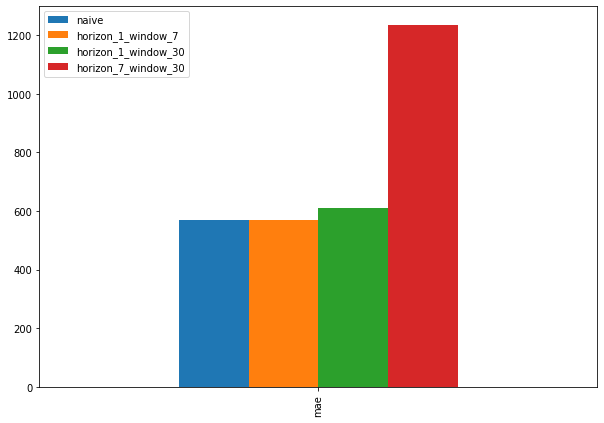

In [ ]:
# Check which model works best so far
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]},
             index=["mae"]).plot(figsize=(10, 7), kind="bar")